# Produce automatic irrigated crop extent rasters

**What does this notebook do?** This notebook generates automatic crop extent maps using maximum NDVI composites, and the 2013 NSW Landuse polygon set to mask the maximum extent.

**Inputs**
- Max NDVI geotiff
- Irrigated crop area .pkl from the [NSW Land Use Mask 2013 dataset](http://data.environment.nsw.gov.au/dataset/nsw-landuse-2013)

**Outputs**
* `AutoIrrigated_<threshold>_<year>.tif`

**Date:** May 2018

**Author:** Claire Krause

In [1]:
%pylab notebook
%load_ext autoreload
%autoreload 2

import xarray as xr
import pickle

import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEADataHandling

Populating the interactive namespace from numpy and matplotlib


## Set up the notebook

In [2]:
year = '2013'
Index = 'NDVI'

In [3]:
StatsFile = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/AutoIrrigated_0.8_{0}.tif'.format(year)

In [4]:
ALUMCropMaskFile = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/ALUM2013_IrrCrop_Namoi_mask.pkl'

In [8]:
# Select a threshold for the irrigated crop maps
NDVIthreshold = 0.80

## Load in the relevant datasets

In [5]:
# Open the pickled mask
with open(ALUMCropMaskFile, 'rb') as f:
    ALUMCropMask = pickle.load(f)

In [6]:
# Open the Geotiff
GeotiffData = xr.open_rasterio(StatsFile)

# Make sure all the missing values are taken out
DatamaxNonull = GeotiffData.where(GeotiffData != -1)

In [7]:
# Mask out any areas not previously identified as irrigated cropping
PotentialCrop = ALUMCropMask * DatamaxNonull

## Let's try producing some automatic irrigated crop extent maps

In [9]:
# Make sure all the missing values are taken out
AutoIrrigated = PotentialCrop.where(PotentialCrop >= NDVIthreshold)

<IPython.core.display.Javascript object>


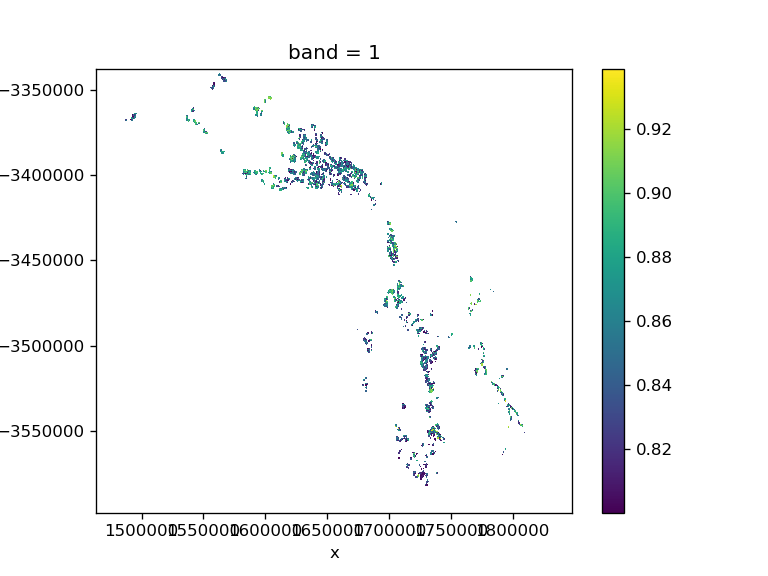

In [10]:
plt.figure()
AutoIrrigated.isel(x = range(0,len(GeotiffData.x),10), y = range(0,len(GeotiffData.y),10)).plot()

In [11]:
AutoIrrigatedDS = AutoIrrigated.to_dataset(name = 'maxNDVI')
AutoIrrigatedDS.attrs['crs'] = GeotiffData.crs
AutoIrrigatedDS.attrs['affine'] = GeotiffData.transform[0:-3]

In [12]:
DEADataHandling.dataset_to_geotiff('AutoIrrigated_0{0}_{1}.tif'.format(str(NDVIthreshold)[-2:], year), 
                                   squeeze(AutoIrrigatedDS))